# QBAF Robustness
This notebook contains some examples for a study of robustness in quantitative bipolar argumentation.


## Setup

As prerequistes, we install and import dependencies, and provide some basic helper code.

In [ ]:
%%capture
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install 'QBAF-Py[Visualizer] @ git+https://github.com/TimKam/Quantitative-Bipolar-Argumentation.git'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from qbaf_visualizer.Visualizer import *
from qbaf_ctrbs.removal import *
from qbaf_ctrbs.intrinsic_removal import *
from qbaf_ctrbs.shapley import *
from qbaf_ctrbs.gradient import *

In [ ]:
def func(contributor_strength, contributor, qbaf, topic):
        initial_strengths = []
        argument_list = list(qbaf.arguments)
        for arg in argument_list:
            if arg == contributor:
                initial_strengths.append(contributor_strength)
            else:
                initial_strengths.append(qbaf.initial_strength(arg))
        qbaf_changed = QBAFramework(argument_list, initial_strengths,
                                    qbaf.attack_relations.relations,
                                    qbaf.support_relations.relations,
                                    semantics=qbaf.semantics)
        return qbaf_changed.final_strength(topic)

## Issues with Robustness of Inference
A fundamental idea underlying formal argumentation is that when facing new information about our environment, we can revise inferences that have drawn.
Accordingly, we do not expect that the inference we draw a generally robust, or even robust in face of strength changes or normal expansions.
Indeed, even in very simple cases, where a single argument appears that is equally connected to both topic arguments, our inference may change.

### DFQuAD Semantics
For DFQuAD semantics, this is the case when the slopes of linear influence of an argument on two topics are different, e.g., because one topic is also influenced by another argument.
Below, we see an example where this leads to a lack of robustness given strength changes.

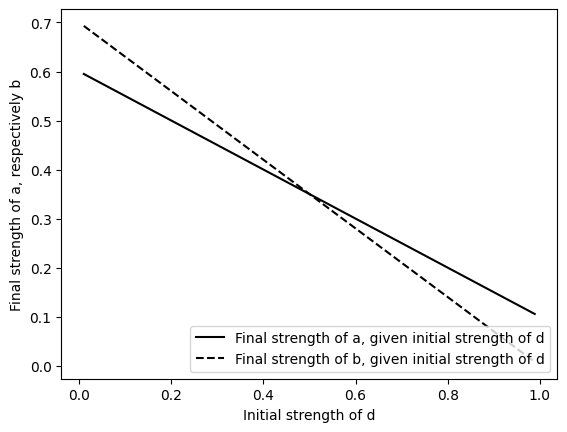

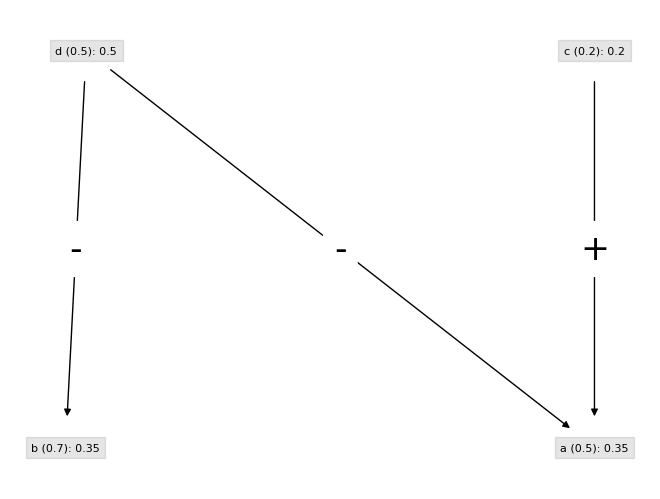

In [ ]:
args = ['a', 'b', 'c', 'd']
initial_strengths = [0.5, 0.7, 0.2, 0.5]
atts = [('d', 'a'), ('d', 'b')]
supps = [('c', 'a')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")


def plot_example():
    ises = []
    fsas = []
    fsfs = []
    for ise in range(10, 990):
        fise = ise / 1000
        ises.append(fise)
        fsas.append(abs(func(fise, 'd', qbaf, 'a')))
        fsfs.append(abs(func(fise, 'd', qbaf, 'b')))
    plt.plot(np.array(ises), np.array(fsas), color='black')
    plt.plot(np.array(ises), np.array(fsfs), color='black', linestyle='--')
    plt.xlabel("Initial strength of d")
    plt.ylabel("Final strength of a, respectively b")
    plt.legend(["Final strength of a, given initial strength of d", "Final strength of b, given initial strength of d"], loc="lower right")
    plt.show()
plot_example()
visualize(qbaf, with_fs=True, round_to=6)

Based on the intersection of the lines in the plot above, we can construct a similar example for the case of normal expansions.

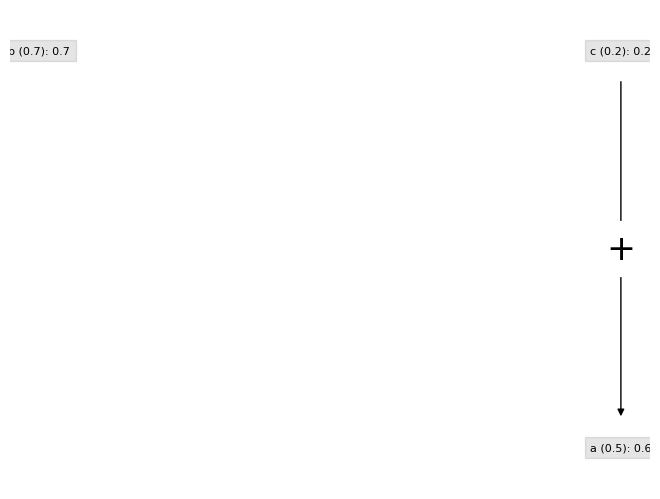

In [ ]:
args = ['a', 'b', 'c']
initial_strengths = [0.5, 0.7, 0.2]
atts = []
supps = [('c', 'a')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")
visualize(qbaf, with_fs=True, round_to=6)

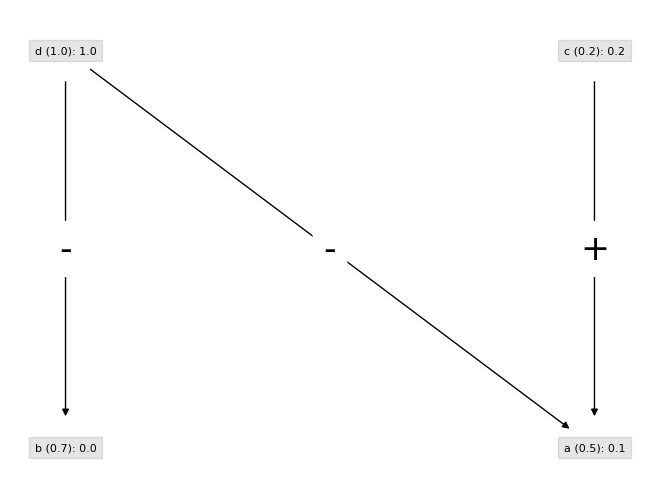

In [ ]:
args = ['a', 'b', 'c', 'd']
initial_strengths = [0.5, 0.7, 0.2, 1]
atts = [('d', 'a'), ('d', 'b')]
supps = [('c', 'a')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")
visualize(qbaf, with_fs=True, round_to=6)

### Quadratic Energy Semantics
For quadratic energy semantics, we can see similar behaviors, just with non-linear influence.

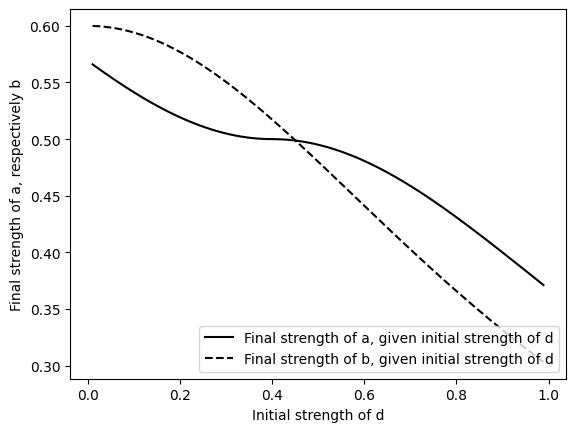

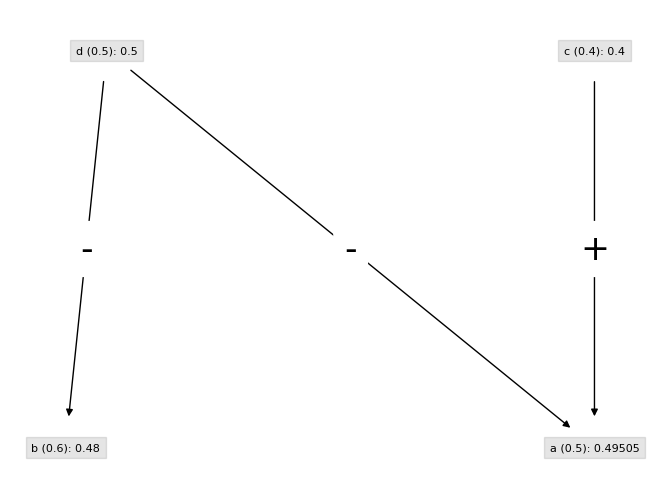

In [ ]:
args = ['a', 'b', 'c', 'd']
initial_strengths = [0.5, 0.6, 0.4, 0.5]
atts = [('d', 'a'), ('d', 'b')]
supps = [('c', 'a')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")


def plot_example():
    ises = []
    fsas = []
    fsfs = []
    for ise in range(10, 990):
        fise = ise / 1000
        ises.append(fise)
        fsas.append(abs(func(fise, 'd', qbaf, 'a')))
        fsfs.append(abs(func(fise, 'd', qbaf, 'b')))
    plt.plot(np.array(ises), np.array(fsas), color='black')
    plt.plot(np.array(ises), np.array(fsfs), color='black', linestyle='--')
    plt.xlabel("Initial strength of d")
    plt.ylabel("Final strength of a, respectively b")
    plt.legend(["Final strength of a, given initial strength of d", "Final strength of b, given initial strength of d"], loc="lower right")
    plt.show()
plot_example()
visualize(qbaf, with_fs=True, round_to=6)

Again, the intersection of the lines in the plot helps us to construct an analogous example for normal expansions.

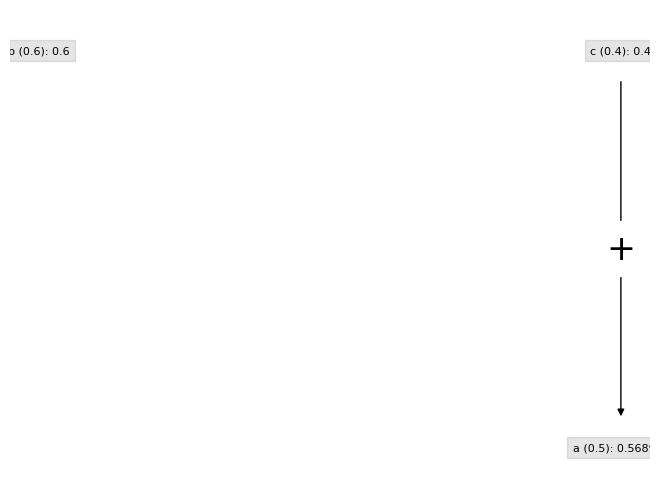

In [ ]:
args = ['a', 'b', 'c']
initial_strengths = [0.5, 0.6, 0.4]
atts = []
supps = [('c', 'a')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")
visualize(qbaf, with_fs=True, round_to=6)

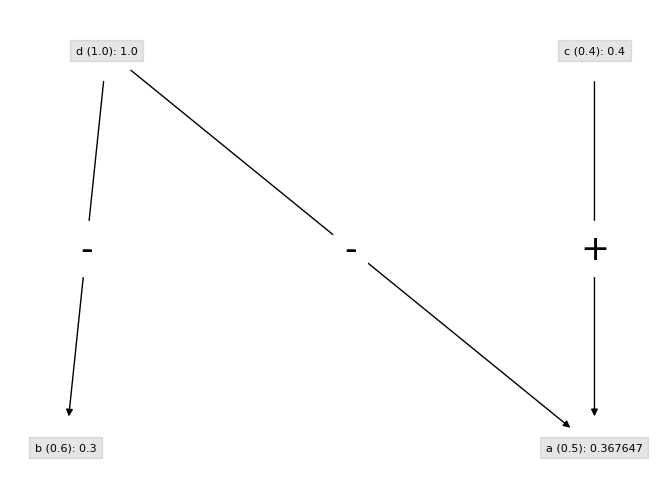

In [ ]:
args = ['a', 'b', 'c', 'd']
initial_strengths = [0.5, 0.6, 0.4, 1]
atts = [('d', 'a'), ('d', 'b')]
supps = [('c', 'a')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")
visualize(qbaf, with_fs=True, round_to=6)

## Issues with Robustness of Inference Change in Face of Non-Monotonic Effects
More interestingly, we can demonstrate that monotonically increasing the final strength of a single argument can lead to robustness issues in that it can first flip $\sigma(\mathsf{a}) > \sigma(\mathsf{b})$ to $\sigma(\mathsf{b}) > \sigma(\mathsf{a})$, to then reverse this change of inference back to $\sigma(\mathsf{a}) > \sigma(\mathsf{b})$.

First, we rely on the well-known issue that the effect of one argument on another does not necessarily increase/decrease weakly monotonically with the former argument's initial strength.

### DFQuAD Semantics
Below, we can see this issue play out for DFQuAD semantics.
The example extends a counter-example provided in Figure 1 by [Kampik et al., 2024](https://arxiv.org/abs/2401.08879), intuitively playing out an argument's monotonic effects on two topic arguments against each other.

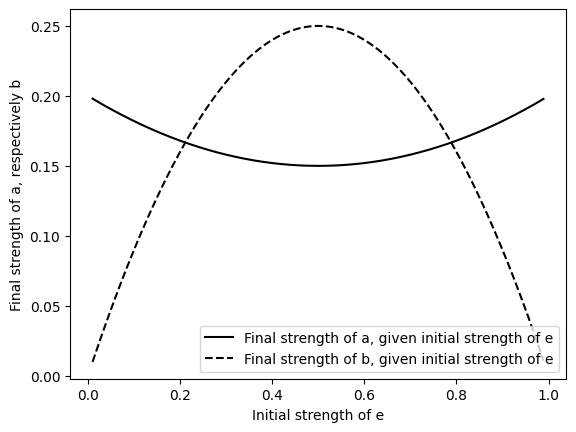

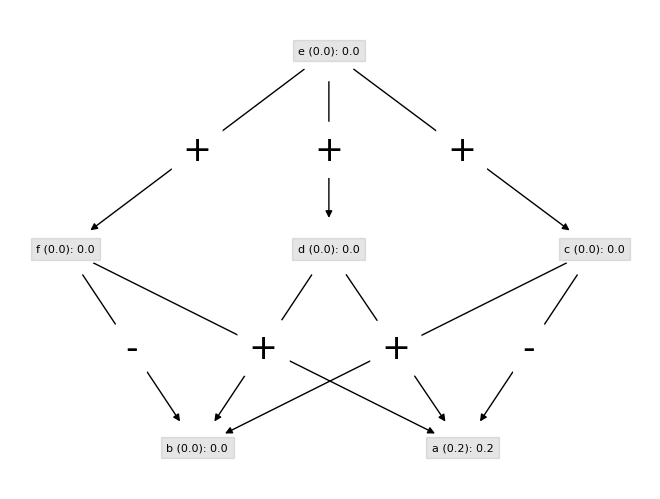

In [ ]:
args = ['a', 'b', 'c', 'd', 'e', 'f']
initial_strengths = [0.2, 0.0, 0.0, 0.0, 0.0, 0.0]
atts = [('c', 'a'), ('d', 'a'), ('f', 'b')]
supps = [('f', 'a'), ('c', 'b'), ('d', 'b'), ('e', 'f'), ('e', 'c'), ('e', 'd')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")
ir_ctrb_e_to_a = determine_iremoval_ctrb('a', 'e', qbaf)
g_ctrb_e_to_a = determine_gradient_ctrb('a', 'e', qbaf)


def plot_example():
    ises = []
    fsas = []
    fsfs = []
    for ise in range(10, 990):
        fise = ise / 1000
        ises.append(fise)
        fsas.append(abs(func(fise, 'e', qbaf, 'a')))
        fsfs.append(abs(func(fise, 'e', qbaf, 'b')))
    plt.plot(np.array(ises), np.array(fsas), color='black')
    plt.plot(np.array(ises), np.array(fsfs), color='black', linestyle='--')
    plt.xlabel("Initial strength of e")
    plt.ylabel("Final strength of a, respectively b")
    plt.legend(["Final strength of a, given initial strength of e", "Final strength of b, given initial strength of e"], loc="lower right")
    plt.show()
plot_example()
visualize(qbaf, with_fs=True, round_to=6)

An analgous example for the case of normal expansions follows below.

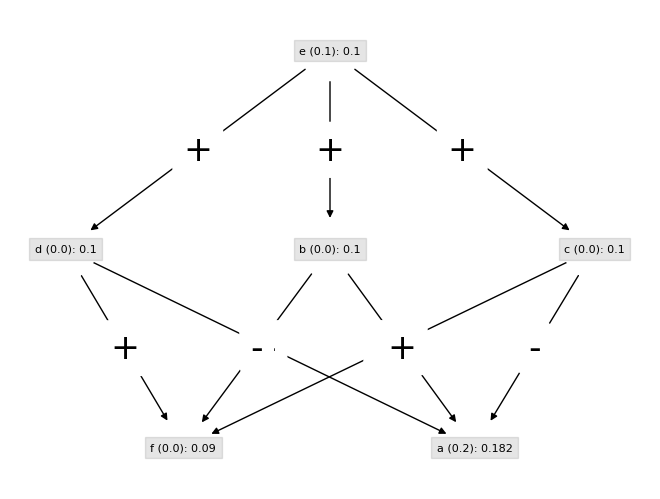

In [ ]:
args = ['a', 'b', 'c', 'd', 'e', 'f']
initial_strengths = [0.2, 0.0, 0.0, 0.0, 0.1, 0.0]
atts = [('c', 'a'), ('d', 'a'), ('b', 'f')]
supps = [('b', 'a'), ('c', 'f'), ('d', 'f'), ('e', 'b'), ('e', 'c'), ('e', 'd')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")
ir_ctrb_e_to_a = determine_iremoval_ctrb('a', 'e', qbaf)
g_ctrb_e_to_a = determine_gradient_ctrb('a', 'e', qbaf)
visualize(qbaf, with_fs=True, round_to=6)

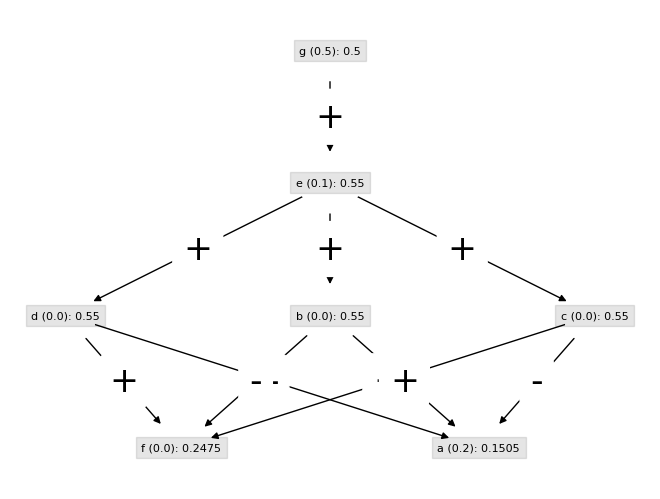

In [ ]:
args = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
initial_strengths = [0.2, 0.0, 0.0, 0.0, 0.1, 0.0, 0.5]
atts = [('c', 'a'), ('d', 'a'), ('b', 'f')]
supps = [('b', 'a'), ('c', 'f'), ('d', 'f'), ('e', 'b'), ('e', 'c'), ('e', 'd'), ('g', 'e')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")
ir_ctrb_e_to_a = determine_iremoval_ctrb('a', 'e', qbaf)
g_ctrb_e_to_a = determine_gradient_ctrb('a', 'e', qbaf)
visualize(qbaf, with_fs=True, round_to=6)

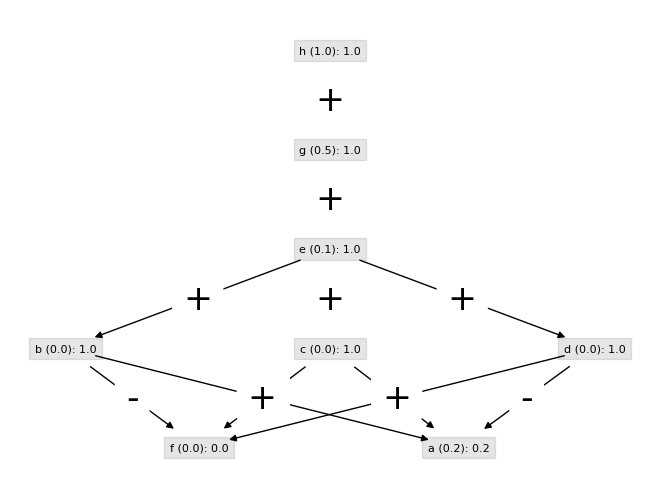

In [ ]:
args = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
initial_strengths = [0.2, 0.0, 0.0, 0.0, 0.1, 0.0, 0.5, 1.0]
atts = [('c', 'a'), ('d', 'a'), ('b', 'f')]
supps = [('b', 'a'), ('c', 'f'), ('d', 'f'), ('e', 'b'), ('e', 'c'), ('e', 'd'), ('g', 'e'), ('h', 'g')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")
ir_ctrb_e_to_a = determine_iremoval_ctrb('a', 'e', qbaf)
g_ctrb_e_to_a = determine_gradient_ctrb('a', 'e', qbaf)
visualize(qbaf, with_fs=True, round_to=6)

### Quadratic Energy Semantics
For quadratic energy semantics, we can find a slightly more involved example, based on a counter-example provided in Figure 1 of [Naudot et al., 2025](https://arxiv.org/abs/2509.14963).

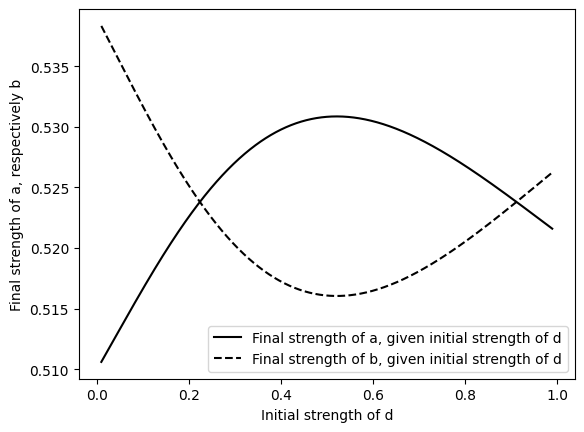

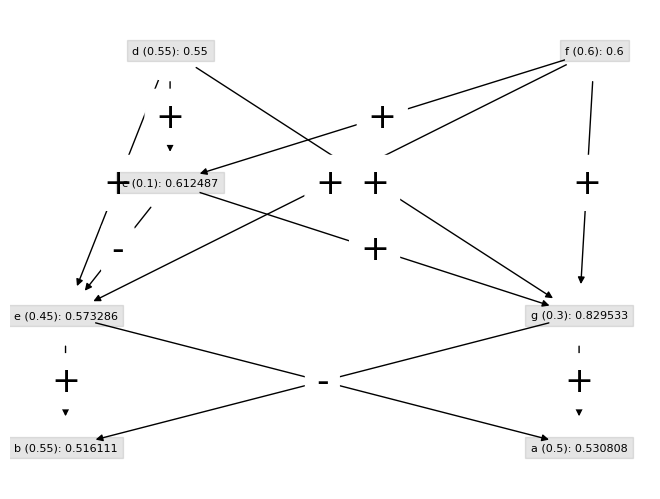

In [ ]:
args = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
initial_strengths = [0.5, 0.55, 0.1, 0.55, 0.45, 0.6, 0.3]
atts = [('g', 'b'), ('c', 'e'), ('e', 'a')]
supps = [('g', 'a'), ('c', 'g'), ('d', 'g'), ('d', 'c'), ('d', 'e'), ('f', 'g'), ('f', 'c'), ('f', 'e'), ('e', 'b')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")


def plot_example():
    ises = []
    fsas = []
    fsfs = []
    for ise in range(10, 990):
        fise = ise / 1000
        ises.append(fise)
        fsas.append(abs(func(fise, 'd', qbaf, 'a')))
        fsfs.append(abs(func(fise, 'd', qbaf, 'b')))
    plt.plot(np.array(ises), np.array(fsas), color='black')
    plt.plot(np.array(ises), np.array(fsfs), color='black', linestyle='--')
    plt.xlabel("Initial strength of d")
    plt.ylabel("Final strength of a, respectively b")
    plt.legend(["Final strength of a, given initial strength of d", "Final strength of b, given initial strength of d"], loc="lower right")
    plt.show()
plot_example()
visualize(qbaf, with_fs=True, round_to=6)

An analgous example for the case of normal expansions follows below.

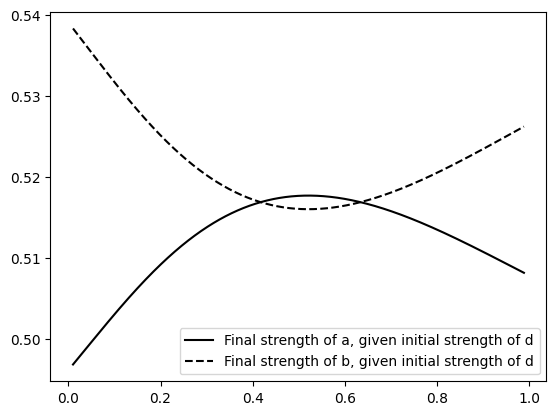

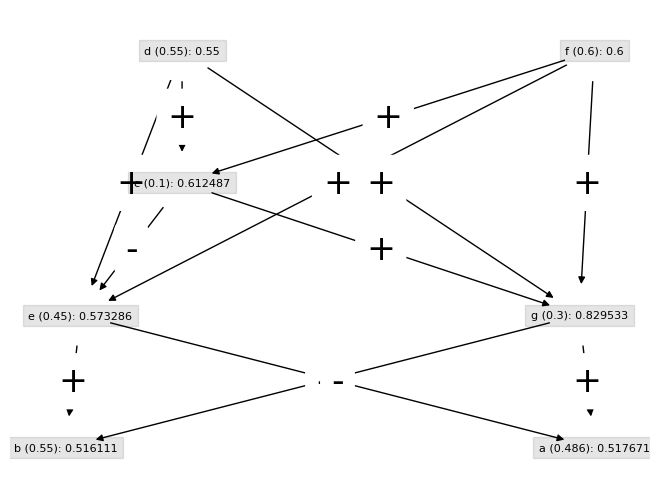

In [ ]:
args = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
initial_strengths = [0.486, 0.55, 0.1, 0.55, 0.45, 0.6, 0.3]
atts = [('g', 'b'), ('c', 'e'), ('e', 'a')]
supps = [('g', 'a'), ('c', 'g'), ('d', 'g'), ('d', 'c'), ('d', 'e'), ('f', 'g'), ('f', 'c'), ('f', 'e'), ('e', 'b')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")


def plot_example():
    ises = []
    fsas = []
    fsfs = []
    for ise in range(10, 990):
        fise = ise / 1000
        ises.append(fise)
        fsas.append(abs(func(fise, 'd', qbaf, 'a')))
        fsfs.append(abs(func(fise, 'd', qbaf, 'b')))
    plt.plot(np.array(ises), np.array(fsas), color='black')
    plt.plot(np.array(ises), np.array(fsfs), color='black', linestyle='--')
    plt.xlabel("Initial strength of d")
    plt.ylabel("Final strength of a, respectively b")
    plt.legend(["Final strength of a, given initial strength of d", "Final strength of b, given initial strength of d"], loc="lower right")
    plt.show()
plot_example()
visualize(qbaf, with_fs=True, round_to=6)

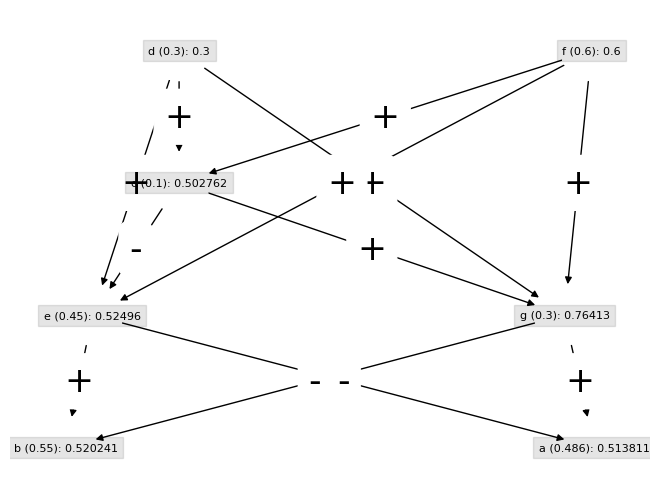

In [ ]:
args = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
initial_strengths = [0.486, 0.55, 0.1, 0.3, 0.45, 0.6, 0.3]
atts = [('g', 'b'), ('c', 'e'), ('e', 'a')]
supps = [('g', 'a'), ('c', 'g'), ('d', 'g'), ('d', 'c'), ('d', 'e'), ('f', 'g'), ('f', 'c'), ('f', 'e'), ('e', 'b')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")
visualize(qbaf, with_fs=True, round_to=6)

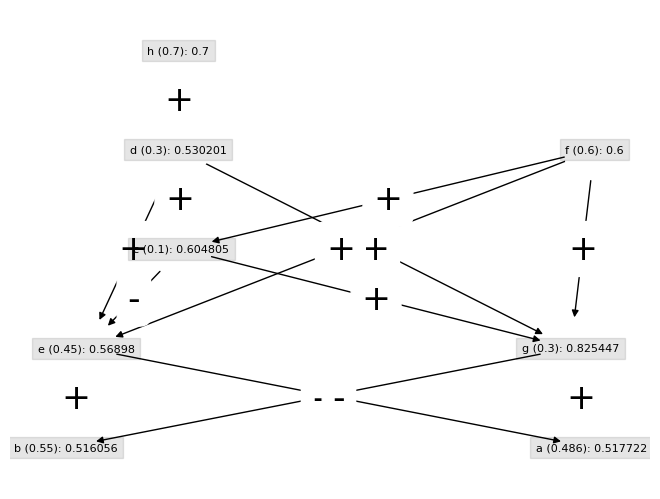

In [ ]:
args = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
initial_strengths = [0.486, 0.55, 0.1, 0.3, 0.45, 0.6, 0.3, 0.7]
atts = [('g', 'b'), ('c', 'e'), ('e', 'a')]
supps = [('g', 'a'), ('c', 'g'), ('d', 'g'), ('d', 'c'), ('d', 'e'), ('f', 'g'), ('f', 'c'), ('f', 'e'), ('e', 'b'), ('h', 'd')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")
visualize(qbaf, with_fs=True, round_to=6)

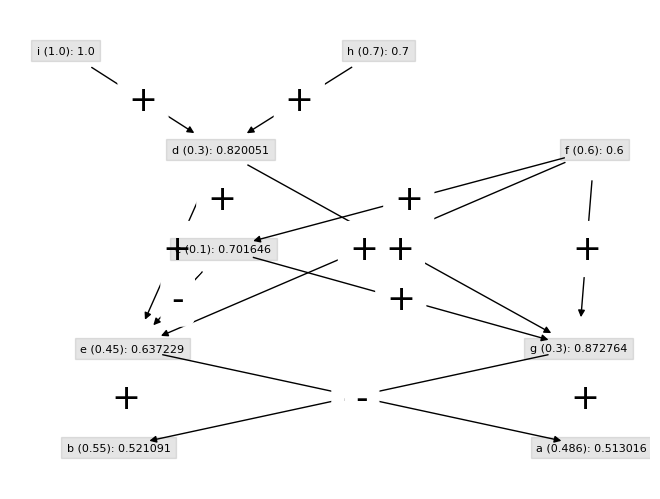

In [ ]:
args = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
initial_strengths = [0.486, 0.55, 0.1, 0.3, 0.45, 0.6, 0.3, 0.7, 1]
atts = [('g', 'b'), ('c', 'e'), ('e', 'a')]
supps = [('g', 'a'), ('c', 'g'), ('d', 'g'), ('d', 'c'), ('d', 'e'), ('f', 'g'), ('f', 'c'), ('f', 'e'), ('e', 'b'), ('h', 'd'), ('i', 'd')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")
visualize(qbaf, with_fs=True, round_to=6)

## Issues with Robustness of Inference Change in Absence of Nonmonotonic Effects
However, similar issues can occur in even simpler scenarios, where the effect
of one argument one another one is necessarily monotonic.
This is because that even given a monotonic direction, the strength of the effect may vary; accordingly, one argument's effect on one topic can be increasingly stronger while its effect on another topic remains the same (or does not increase substantially in strength).

### DFQuAD Semantics
For DFQuAD semantics, we can construct a corresponding counter-example that features two topic arguments of different initial strengths that have the same supporter but feature separate attackers.
The topic argument with the greater initial strength is attacked by an argument somewhat stronger than the attacker of topic argument with the lesser initial strength.

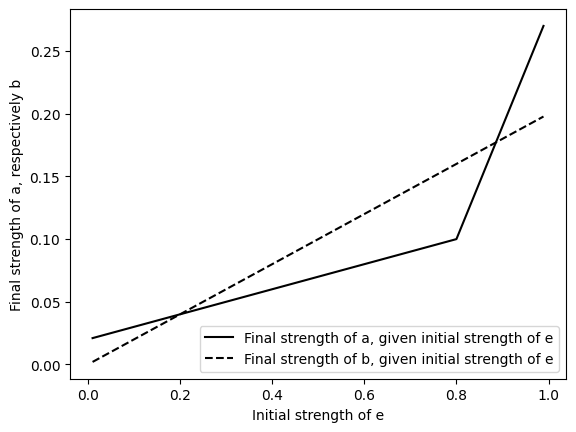

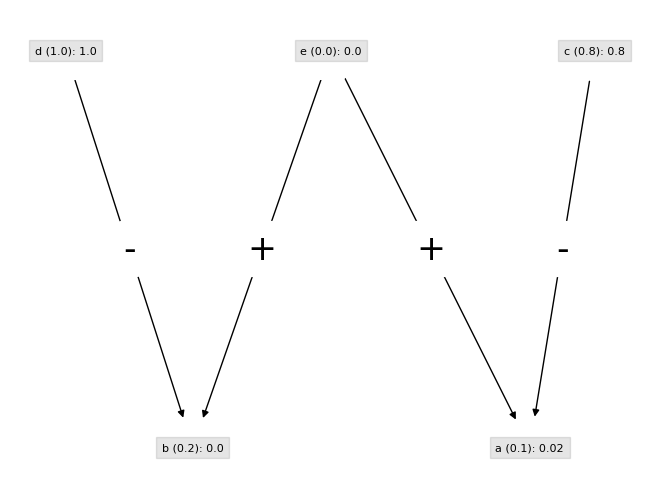

In [ ]:
args = ['a', 'b', 'c', 'd', 'e']
initial_strengths = [0.1, 0.2, 0.8, 1.0, 0.0]
atts = [('c', 'a'), ('d', 'b')]
supps = [('e', 'a'), ('e', 'b')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")


def plot_example():
    ises = []
    fsas = []
    fsfs = []
    for ise in range(10, 990):
        fise = ise / 1000
        ises.append(fise)
        fsas.append(abs(func(fise, 'e', qbaf, 'a')))
        fsfs.append(abs(func(fise, 'e', qbaf, 'b')))
    plt.plot(np.array(ises), np.array(fsas), color='black')
    plt.plot(np.array(ises), np.array(fsfs), color='black', linestyle='--')
    plt.xlabel("Initial strength of e")
    plt.ylabel("Final strength of a, respectively b")
    plt.legend(["Final strength of a, given initial strength of e", "Final strength of b, given initial strength of e"], loc="lower right")
    plt.show()
plot_example()
visualize(qbaf, with_fs=True, round_to=6)

An analgous example for the case of normal expansions follows below.

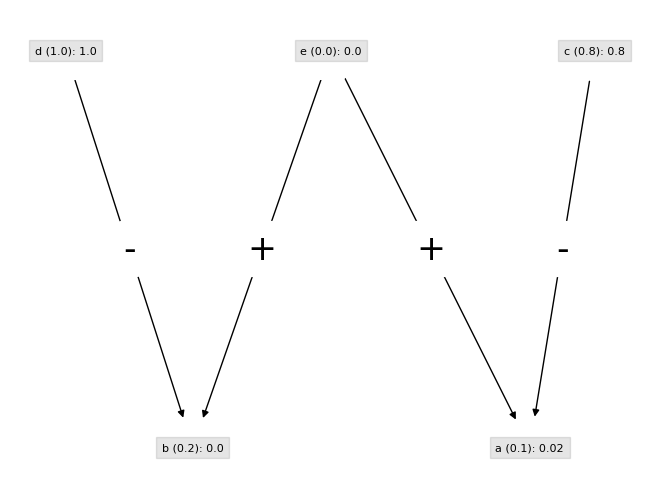

In [ ]:
args = ['a', 'b', 'c', 'd', 'e']
initial_strengths = [0.1, 0.2, 0.8, 1.0, 0.0]
atts = [('c', 'a'), ('d', 'b')]
supps = [('e', 'a'), ('e', 'b')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")
visualize(qbaf, with_fs=True, round_to=6)

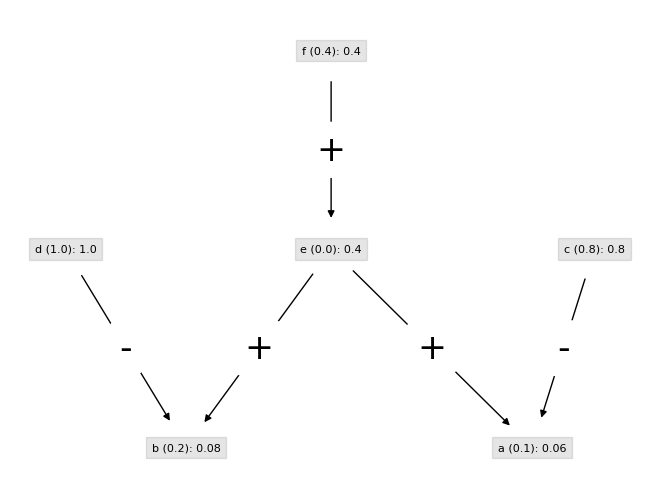

In [ ]:
args = ['a', 'b', 'c', 'd', 'e', 'f']
initial_strengths = [0.1, 0.2, 0.8, 1.0, 0.0, 0.4]
atts = [('c', 'a'), ('d', 'b')]
supps = [('e', 'a'), ('e', 'b'), ('f', 'e')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")
visualize(qbaf, with_fs=True, round_to=6)

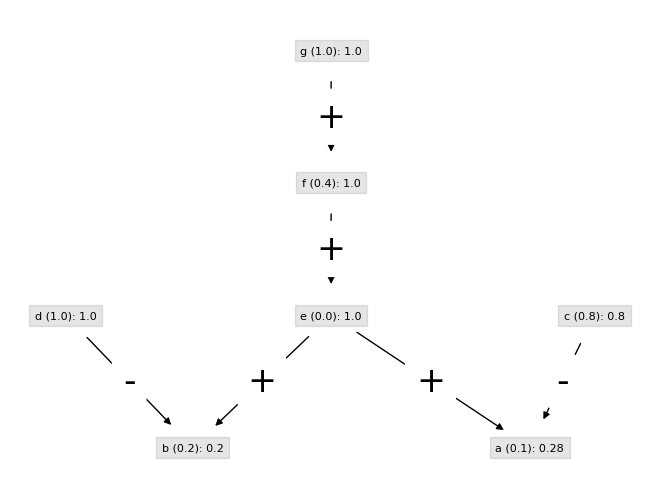

In [ ]:
args = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
initial_strengths = [0.1, 0.2, 0.8, 1.0, 0.0, 0.4, 1]
atts = [('c', 'a'), ('d', 'b')]
supps = [('e', 'a'), ('e', 'b'), ('f', 'e'), ('g', 'f')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")
visualize(qbaf, with_fs=True, round_to=6)

## Quadratic Energy Semantics
For quadratic energy semantics a similar example applies, with the same graph topology but different initial strengths.

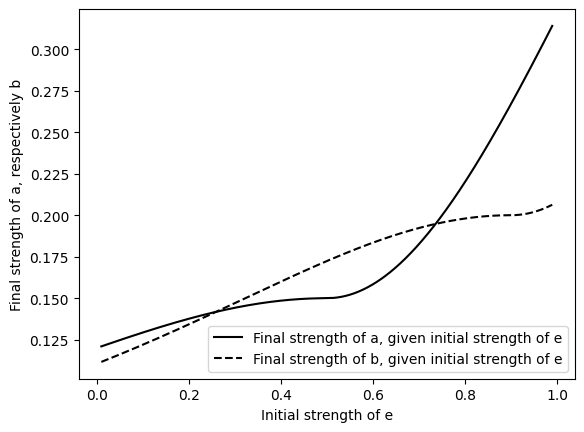

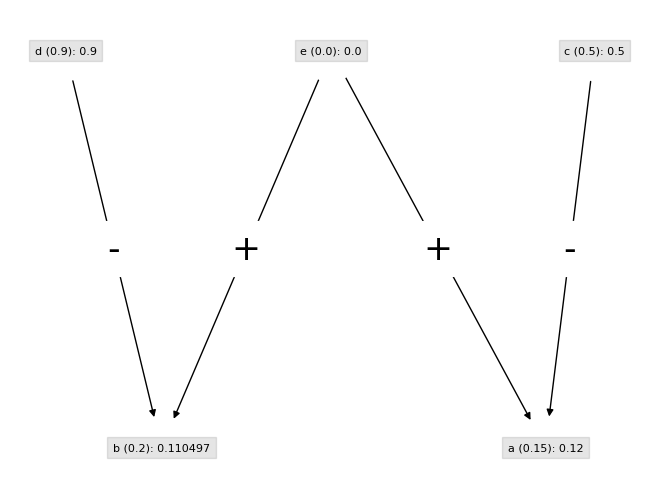

In [ ]:
args = ['a', 'b', 'c', 'd', 'e']
initial_strengths = [0.15, 0.2, 0.5, 0.9, 0.0]
atts = [('c', 'a'), ('d', 'b')]
supps = [('e', 'a'), ('e', 'b')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")


def plot_example():
    ises = []
    fsas = []
    fsfs = []
    for ise in range(10, 990):
        fise = ise / 1000
        ises.append(fise)
        fsas.append(abs(func(fise, 'e', qbaf, 'a')))
        fsfs.append(abs(func(fise, 'e', qbaf, 'b')))
    plt.plot(np.array(ises), np.array(fsas), color='black')
    plt.plot(np.array(ises), np.array(fsfs), color='black', linestyle='--')
    plt.xlabel("Initial strength of e")
    plt.ylabel("Final strength of a, respectively b")
    plt.legend(["Final strength of a, given initial strength of e", "Final strength of b, given initial strength of e"], loc="lower right")
    plt.show()
plot_example()
visualize(qbaf, with_fs=True, round_to=6)

An analgous example for the case of normal expansions follows below.

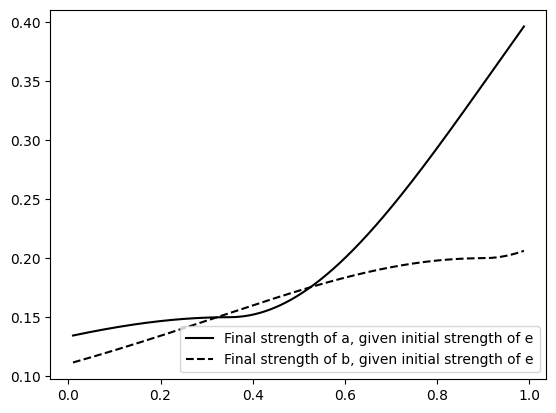

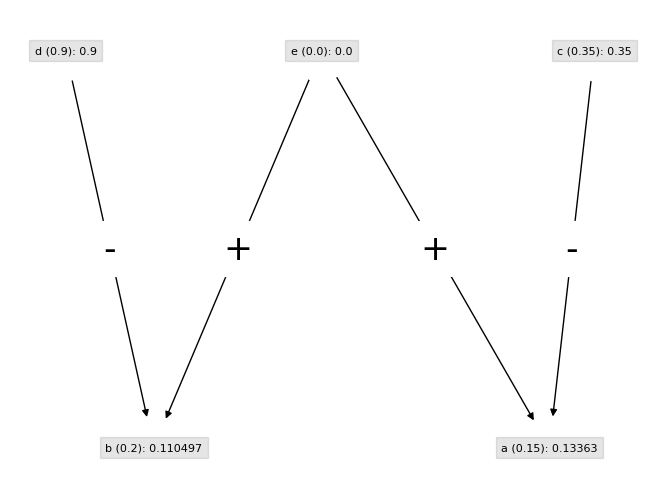

In [ ]:
args = ['a', 'b', 'c', 'd', 'e']
initial_strengths = [0.15, 0.2, 0.35, 0.9, 0.0]
atts = [('c', 'a'), ('d', 'b')]
supps = [('e', 'a'), ('e', 'b')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")


def plot_example():
    ises = []
    fsas = []
    fsfs = []
    for ise in range(10, 990):
        fise = ise / 1000
        ises.append(fise)
        fsas.append(abs(func(fise, 'e', qbaf, 'a')))
        fsfs.append(abs(func(fise, 'e', qbaf, 'b')))
    plt.plot(np.array(ises), np.array(fsas), color='black')
    plt.plot(np.array(ises), np.array(fsfs), color='black', linestyle='--')
    plt.legend(["Final strength of a, given initial strength of e", "Final strength of b, given initial strength of e"], loc="lower right")
    plt.show()
plot_example()
visualize(qbaf, with_fs=True, round_to=6)

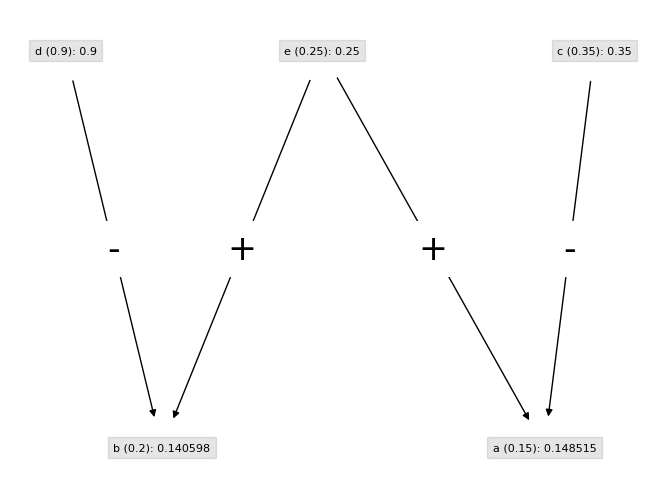

In [ ]:
args = ['a', 'b', 'c', 'd', 'e']
initial_strengths = [0.15, 0.2, 0.35, 0.9, 0.25]
atts = [('c', 'a'), ('d', 'b')]
supps = [('e', 'a'), ('e', 'b')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")
visualize(qbaf, with_fs=True, round_to=6)

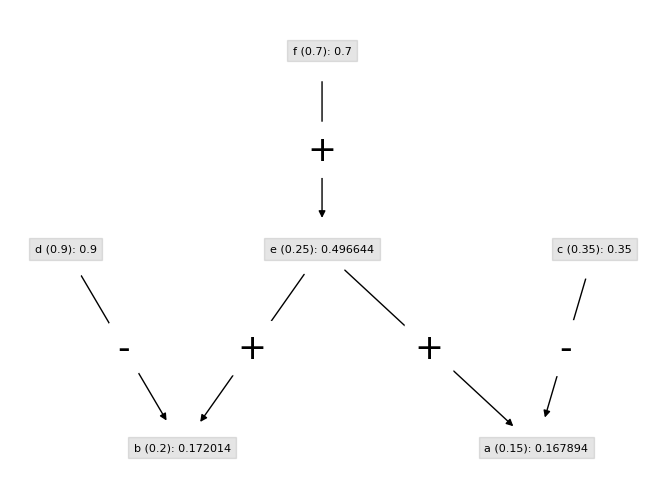

In [ ]:
args = ['a', 'b', 'c', 'd', 'e', 'f']
initial_strengths = [0.15, 0.2, 0.35, 0.9, 0.25, 0.7]
atts = [('c', 'a'), ('d', 'b')]
supps = [('e', 'a'), ('e', 'b'), ('f', 'e')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")
visualize(qbaf, with_fs=True, round_to=6)

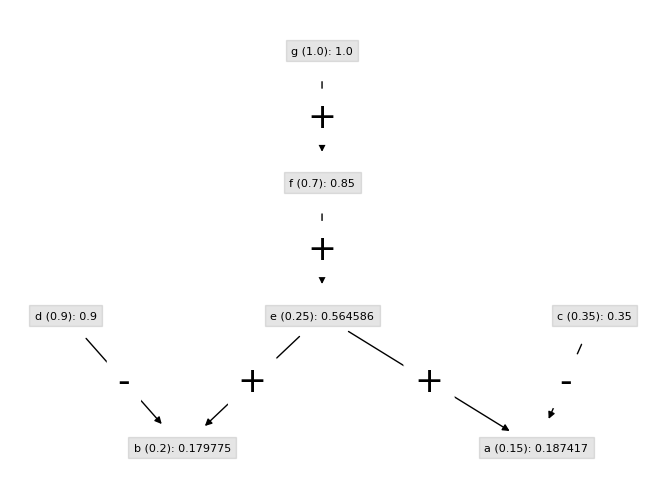

In [ ]:
args = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
initial_strengths = [0.15, 0.2, 0.35, 0.9, 0.25, 0.7, 1]
atts = [('c', 'a'), ('d', 'b')]
supps = [('e', 'a'), ('e', 'b'), ('f', 'e'), ('g', 'f')]
qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")
visualize(qbaf, with_fs=True, round_to=6)